C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:54:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy Comparison:
            Model  Accuracy
0  Decision Tree     0.975
1  Random Forest     0.995
2        XGBoost     0.985

Best model and preprocessing objects saved.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best model and preprocessing objects loaded successfully.

Prediction for the input data: danger


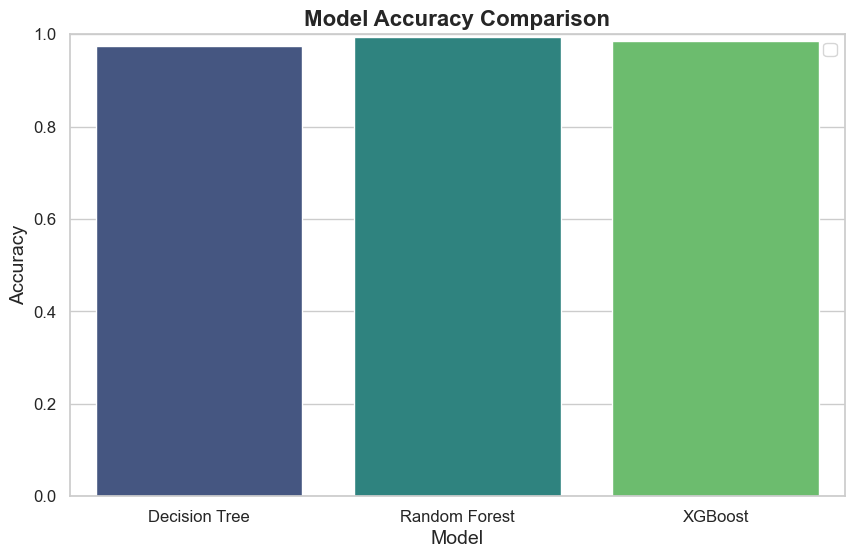

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("deforestation_dataset_2015_2024.csv")

# Encode categorical variables (Country and Region)
label_encoder_country = LabelEncoder()
label_encoder_region = LabelEncoder()
df["Country"] = label_encoder_country.fit_transform(df["Country"])
df["Region"] = label_encoder_region.fit_transform(df["Region"])

# Separate features (X) and target (y)
X = df.drop(columns=["Label"])  # Features
y = df["Label"]  # Target

# Encode the target variable (y) into numerical values
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Add noise to the features
np.random.seed(42)
noise = np.random.normal(0, 0.001, X.shape)  # Gaussian noise with mean=0 and std=0.001
X_noisy = X + noise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y_encoded, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Train and evaluate models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Get accuracies
dt_accuracy = train_and_evaluate(dt_model, X_train, X_test, y_train, y_test)
rf_accuracy = train_and_evaluate(rf_model, X_train, X_test, y_train, y_test)
xgb_accuracy = train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test)

# Create a comparison table
accuracy_comparison = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [dt_accuracy, rf_accuracy, xgb_accuracy]
})

print("Accuracy Comparison:\n", accuracy_comparison)

# Save the best model (XGBoost in this case)
best_model = xgb_model
joblib.dump(best_model, "best_deforestation_model.pkl")
joblib.dump(label_encoder_country, "label_encoder_country.pkl")
joblib.dump(label_encoder_region, "label_encoder_region.pkl")
joblib.dump(label_encoder_target, "label_encoder_target.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\nBest model and preprocessing objects saved.")

# Load the saved model and preprocessing objects
loaded_model = joblib.load("best_deforestation_model.pkl")
loaded_label_encoder_country = joblib.load("label_encoder_country.pkl")
loaded_label_encoder_region = joblib.load("label_encoder_region.pkl")
loaded_label_encoder_target = joblib.load("label_encoder_target.pkl")
loaded_scaler = joblib.load("scaler.pkl")
print("Best model and preprocessing objects loaded successfully.")

# Function to make predictions on new input data
def predict_deforestation(input_data):
    # Preprocess the input data
    input_data = input_data.copy()
    
    # Encode Country and Region
    input_data["Country"] = loaded_label_encoder_country.transform([input_data["Country"]])[0] if input_data["Country"] in loaded_label_encoder_country.classes_ else -1
    input_data["Region"] = loaded_label_encoder_region.transform([input_data["Region"]])[0] if input_data["Region"] in loaded_label_encoder_region.classes_ else -1
    
    # Create a DataFrame
    input_df = pd.DataFrame([input_data])

    # Standardize the input data
    input_scaled = loaded_scaler.transform(input_df)

    # Make prediction
    prediction = loaded_model.predict(input_scaled)
    prediction_label = loaded_label_encoder_target.inverse_transform(prediction)[0]
    return prediction_label

# Example input data for prediction
input_data = {
    "Year": 2021,
    "Country": "Brazil",
    "Region": "Amazon",
    "Forest_Area_km2": 1861303,
    "Population_Density": 27,
    "Agricultural_Land_Percent": 42.93,
    "Rainfall_mm": 1557.33,
    "Temperature_C": 25.36,
    "Road_Density_km_per_km2": 0.19,
    "Mining_Activity": 0.096,
    "Protected_Area_Percent": 10.82,
    "Deforestation_Rate": 0.027,
    "Fire_Incidents": 42,
    "Logging_Activity": 0.107,
    "Urban_Expansion_Rate": 0.542,
    "Carbon_Emissions_kt": 6049
}

# Make prediction
prediction = predict_deforestation(input_data)
print(f"\nPrediction for the input data: {prediction}")

# Set Seaborn style for attractive visualization
sns.set(style="whitegrid", palette="pastel")

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=accuracy_comparison, hue="Model", dodge=False, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=16, fontweight="bold")
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.show()